In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from skimage.io import imread, imshow
import skimage.transform
import matplotlib.pyplot as plt

### Prepare the Dataset

In [ ]:
source_path = "/content/drive/MyDrive/Flood/S2Hand/"
label_path = "/content/drive/MyDrive/Flood/LabelHand/"

source = []
label = []
for file in os.listdir(source_path):
    if file.endswith("tif"):
      source.append(file)

for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)

In [ ]:
## SAnity Check
source = sorted(source)
label = sorted(label)
print(len(source))
print(len(label))

577
577


In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 5


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [ ]:
X = np.zeros((len(source), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(label),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [ ]:
for count, file in enumerate(source):
    source_img = imread(source_path +'/' +file ) #[0:2,:,:]
    # print(f"the shape of the source image: {source_img.shape}")
    new_image = np.transpose(source_img, (1, 2, 0))
    X[count] = new_image


for count, file in enumerate(label):
    slabel_img = imread(label_path + '/'+file ) #[:,:,:,IMG_CHANNELS]
    y = np.expand_dims(slabel_img, axis=2)
    # print(f"The shape of y labels: {y.min()}")
    Y[count] = y

In [ ]:
# Sanity Check
print(X.shape)
print(Y.shape)

(577, 128, 128, 5)
(577, 128, 128, 1)


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y_resahped = Y.reshape(-1,1)
Y_resahped_encoded = labelencoder.fit_transform(Y_resahped)
Y_original = Y_resahped_encoded.reshape(577,128,128,1)
print(np.unique(Y_original))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2]


### Define The UNET

In [ ]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9) #sigmoid

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 5)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 5)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            736 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,427 (7.41 MB)

 Trainable params: 1,941,427 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

### Train The model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y_original, test_size=0.30)

In [ ]:
from keras.utils import to_categorical
train_mask_cat = to_categorical(y_train, num_classes=3)
y_train_cat = train_mask_cat.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2],3)
print(y_train_cat.shape) # Sanity Check

(403, 128, 128, 3)


In [ ]:
test_mask_cat = to_categorical(y_test, num_classes=3)
y_test_cat = test_mask_cat.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 3)
print(y_test_cat.shape) # Sanity Check

(174, 128, 128, 3)


In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_S2Hand.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
    checkpointer
]

results = model.fit(x_train, y_train_cat, validation_split=0.1, batch_size=12, epochs=200, callbacks=callbacks)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4920 - loss: 1.0913
Epoch 1: val_loss improved from inf to 0.92090, saving model to model_S2Hand.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 520ms/step - accuracy: 0.4938 - loss: 1.0887 - val_accuracy: 0.5391 - val_loss: 0.9209
Epoch 2/200
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6043 - loss: 0.9018
Epoch 2: val_loss did not improve from 0.92090
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6030 - loss: 0.9041 - val_accuracy: 0.5392 - val_loss: 0.9361
Epoch 3/200
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5988 - loss: 0.9198
Epoch 3: val_loss did not improve from 0.92090
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5976 - loss: 0.9216 - val_accuracy: 0.5392 - val_loss: 0.9231
Epoch 4/200
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5974 - loss: 0.9279
Epoch 4: val_loss improved from 0.92090 to 0.91481, saving model to model_S2Hand.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step 

### Evaluate the model on the test data

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test_cat, batch_size=12)
print("test loss, test acc:", results)

Evaluate on test data
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.6352 - loss: 0.8919
test loss, test acc: [0.8229089379310608, 0.6725754737854004]


In [ ]:
# IoU
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred,  axis=3)

from keras.metrics import MeanIoU
n_classes = 3
IoU_Keras = MeanIoU(num_classes=n_classes)
IoU_Keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU: ", IoU_Keras.result().numpy())

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step
Mean IoU:  0.31998503


### Classification Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 128, 128)
[0 1]


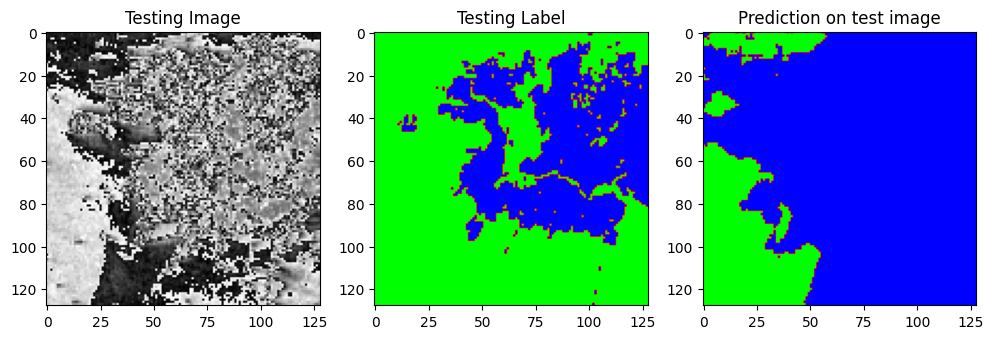

In [ ]:
import random
test_img_number = 10 #10, 36
test_img = x_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img=np.argmax(prediction, axis=3)
print(predicted_img.shape)
print(np.unique(predicted_img))


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='brg')
plt.imsave('UNET_S2Hand_TestLabel.jpg', prediction, cmap='brg')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img[0,:,:], cmap='brg')
plt.imsave('UNET_S2Hand_Predicted.jpg', prediction, cmap='brg')
plt.show()